In [2]:
#import tensorflow as tf 
#!pip install gpflow --user
#from tensorflow.python.client import device_lib

#def get_available_gpus():
#    local_device_protos = device_lib.list_local_devices()
#    return [x.name for x in local_device_protos if x.device_type == 'GPU']
#get_available_gpus()
#device_lib.list_local_devices()
#!pip install seaborn --user
#!export PATH=$PATH:~/.local/bin
#!source activate theanoGPU
#import theano
!pip install pymc3==3.6 --user
!pip freeze

  Found existing installation: pymc3 3.7
    Uninstalling pymc3-3.7:
      Successfully uninstalled pymc3-3.7
alabaster==0.7.12
anaconda-client==1.7.2
anaconda-project==0.8.2
asn1crypto==0.24.0
astroid==2.2.5
astropy==3.1.2
atomicwrites==1.3.0
attrs==19.1.0
Babel==2.6.0
backcall==0.1.0
backports.os==0.1.1
backports.shutil-get-terminal-size==1.0.0
beautifulsoup4==4.7.1
bitarray==0.8.3
bkcharts==0.2
bleach==3.1.0
blessings==1.7
bokeh==1.0.4
boto==2.49.0
Bottleneck==1.2.1
certifi==2019.3.9
cffi==1.12.2
chardet==3.0.4
Click==7.0
cloudpickle==0.8.0
clyent==1.2.2
colorama==0.4.1
community==1.0.0b1
contextlib2==0.5.5
cryptography==2.6.1
cycler==0.10.0
Cython==0.29.6
cytoolz==0.9.0.1
dask==1.1.4
decorator==4.4.0
defusedxml==0.6.0
distributed==1.26.0
docutils==0.14
entrypoints==0.3
et-xmlfile==1.0.1
fastcache==1.0.2
Flask==1.0.2
gevent==1.4.0
gmpy2==2.0.8
gpflow==1.2.0
gpustat==0.5.0
greenlet==0.4.15
h5py==2.9.0
heapdict==1.0.0
html5lib==1.0.1
idna==2.8
imageio==2.5.0
imagesize==1.1.0
importlib

In [ ]:
from theano import function, config, shared, tensor
import numpy
import time

vlen = 10 * 30 * 768  # 10 x #cores x # threads per core
iters = 1000

rng = numpy.random.RandomState(22)
x = shared(numpy.asarray(rng.rand(vlen), config.floatX))
f = function([], tensor.exp(x))
print(f.maker.fgraph.toposort())
t0 = time.time()
for i in range(iters):
    r = f()
t1 = time.time()
print("Looping %d times took %f seconds" % (iters, t1 - t0))
print("Result is %s" % (r,))
if numpy.any([isinstance(x.op, tensor.Elemwise) and
              ('Gpu' not in type(x.op).__name__)
              for x in f.maker.fgraph.toposort()]):
    print('Used the cpu')
else:
    print('Used the gpu')

[Elemwise{exp,no_inplace}(<TensorType(float64, vector)>)]


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import pandas as pd
#import seaborn as sns
import theano.tensor as tt
from sklearn.model_selection import train_test_split

#sns.set(style='white', palette='deep', color_codes=True)

%matplotlib inline

block0 = pd.read_csv('/gpfs/projects/UITS/IUNI/IMAGENE/Phom_output/subFeaturesAll.csv')
data = block0[['AGE','EDU','GENDER','DX']]
mask = np.isfinite(data['AGE'])
data = data[mask]
#data.DX.unique()
train, test = train_test_split(data, test_size=0.2, stratify=data.DX)
maskT = data.index.isin(train.index)
len(maskT)

155

In [4]:
K1 = pd.read_csv('/gpfs/projects/UITS/IUNI/IMAGENE/workingdir/yan30/thickPH0thinKernelPD.tsv', header=None, sep='\t').values
K1 = K1[mask,:]
K1 = K1[:,mask]
K1Tr = K1[maskT,:]
K1Tr = K1Tr[:,maskT]
K2 = pd.read_csv('/gpfs/projects/UITS/IUNI/IMAGENE/workingdir/yan30/thickPH1thinKernelPD.tsv', header=None, sep='\t').values
K2 = K2[mask,:]
K2 = K2[:,mask]
K2Tr = K2[maskT,:]
K2Tr = K2Tr[:,maskT]
n = len(K2Tr)
#K2Tr = K2Tr + 1e4 * np.eye(n)
np.linalg.cholesky(K2Tr)
#K1Tr = K1Tr + 1e4 * np.eye(n)
np.linalg.cholesky(K1Tr)

array([[ 3.00434200e+01,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 3.77391368e+01,  3.51964690e+01,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 3.96012993e+01,  4.41392573e+01,  1.96437016e+01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 3.42679134e+01,  8.89186029e-01, -6.81950182e-01, ...,
         1.27016692e-01,  0.00000000e+00,  0.00000000e+00],
       [ 3.67068138e+01,  5.37029186e+00, -2.54771992e+00, ...,
        -1.03910390e-02,  1.20271302e-01,  0.00000000e+00],
       [ 3.71795670e+01,  7.88086674e+00, -3.29412301e+00, ...,
        -1.78520061e-03,  1.80527483e-03,  5.59449643e-02]])

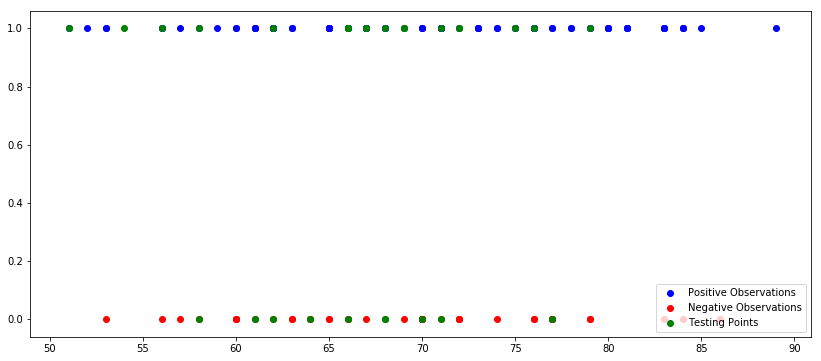

In [5]:
# Number of training points
n = len(train)
X0 = train[['AGE']].values

# Number of testing points
m = len(test)
X = test[['AGE']].values

n = len(train)
Y0 = train[['DX']].values
Y = test[['DX']].values
# Separate data into positive and negative classes
Y[Y == 'MCI'] = 1
Y[Y == 'NC'] = 0
Y0[Y0 == 'MCI'] = 1
Y0[Y0 == 'NC'] = 0

fig, ax = plt.subplots(figsize=(14, 6));
ax.scatter(X0, np.ma.masked_where(Y0 == 0, Y0), color='b', label='Positive Observations');
ax.scatter(X0, np.ma.masked_where(Y0 == 1, Y0), color='r', label='Negative Observations');
ax.scatter(X, Y, color='g', label='Testing Points');
ax.legend(loc='lower right');
#ax.set_xlim(-0.1, 3.1);
#ax.set_ylim(-0.2, 1.2);

In [10]:
with pm.Model() as model:
    # Again, f_sample is just a dummy variable
    f_sample = pm.Flat('f_sample', shape=n)
    f_transform = pm.invlogit(f_sample)

    # Binomial likelihood
    
    y = pm.Binomial('y', observed=Y0, n=np.ones(n), p=f_transform, shape=n)

    # Interpolate function values using noiseless covariance matrix
    # Covariance kernel parameters
    l = 0.3 #= pm.Gamma("l", alpha=2, beta=2)
    # informative, positive normal prior on the period
    eta = pm.HalfNormal("eta",tau=1/5)
    eta2 = pm.HalfNormal("eta2",tau=1/5)
    cov = pm.gp.cov.ExpQuad(1, l) + eta**2 *K1Tr + eta2**2 *K2Tr
    cov0 = pm.gp.cov.ExpQuad(1, l)
    #noise = 0.1

    #cov = f_scale * pm.gp.cov.ExpQuad(1, lengthscale)
    K = cov(X0)
    K_s = cov0(X0, X)
    #K_noise = K + noise * np.eye(n)

    # Add very slight perturbation to the covariance matrix diagonal to improve numerical stability
    K_stable = K + 1e-12 * np.eye(n)

    L = tt.slinalg.cholesky(K_stable)
    f_pred = pm.Deterministic('f_pred', tt.dot(K_s.T, tt.slinalg.solve(L.T, tt.slinalg.solve(L, f_transform))))

    # Use elliptical slice sampling
    ess_step = pm.EllipticalSlice(vars=[f_sample], prior_cov=K_stable)
    trace99 = pm.sample(50000, tuning = 5000, target_accept=0.99, progressbar=True, step=[ess_step], chains = 8, cores = 1)

Sequential sampling (8 chains in 1 job)
CompoundStep
>EllipticalSlice: [f_sample]
>NUTS: [eta2, eta]
 52%|█████▏    | 26251/50500 [32:11<28:49, 14.02it/s]  
There were 106 divergences after tuning. Increase `target_accept` or reparameterize.
There were 219 divergences after tuning. Increase `target_accept` or reparameterize.
There were 337 divergences after tuning. Increase `target_accept` or reparameterize.
There were 441 divergences after tuning. Increase `target_accept` or reparameterize.
There were 553 divergences after tuning. Increase `target_accept` or reparameterize.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [6]:
with pm.Model() as model:
    # covariance function
    l = 0.3 #pm.Gamma("l", alpha=2, beta=2)
    # informative, positive normal prior on the period
    eta = pm.HalfNormal("eta",tau=1/5)
    eta2 = pm.HalfNormal("eta2",tau=1/5)
    cov = pm.gp.cov.ExpQuad(1, l) + eta**2 *K1Tr + eta2**2 *K2Tr
    
    gp = pm.gp.Latent(cov_func=cov)

    # make gp prior
    f = gp.prior("f", X=X0)

    # logit link and Bernoulli likelihood
    p = pm.Deterministic("p", pm.math.invlogit(f))
    y_ = pm.Bernoulli("y", p=p, observed=Y0)

    trace2 = pm.sample(2000, tuning = 800, progressbar=True, chains = 4, cores = 8)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/N/soft/rhel7/deeplearning/Python-3.6.8/lib/python3.6/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


TypeError: function() got an unexpected keyword argument 'tuning'

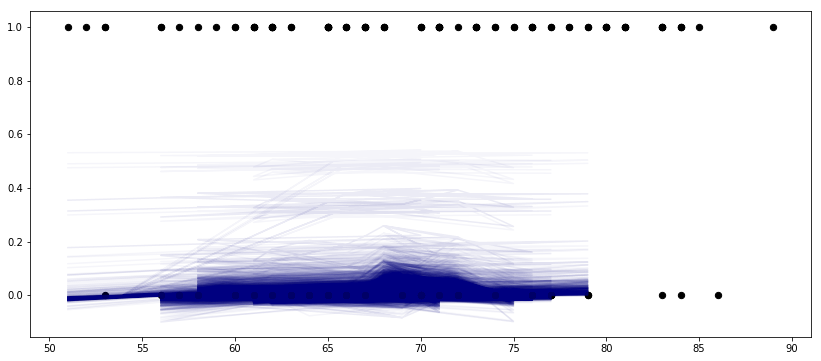

In [11]:
fig, ax = plt.subplots(figsize=(14, 6));
for idx in np.random.randint(4000, 5000, 500):
    ax.plot(X, trace99['f_pred'][idx],  alpha=0.04, color='navy')
ax.scatter(X0, Y0, s=40, color='k');
#ax.set_xlim(0, 3);
#ax.set_ylim(-0.1, 1.1);

In [12]:
pm.summary(trace99, varnames=['eta', 'eta2'])
#pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
eta,1.788382,1.347402,0.005841,0.000039,4.388238,66132.154384,1.000033
eta2,1.779022,1.347238,0.003268,0.000005,4.388488,129516.168362,1.000005


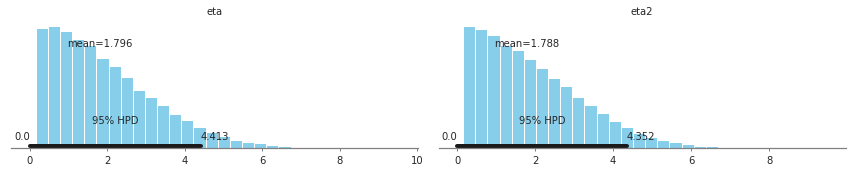

In [59]:
pm.plot_posterior(trace99, varnames=['eta', 'eta2']);

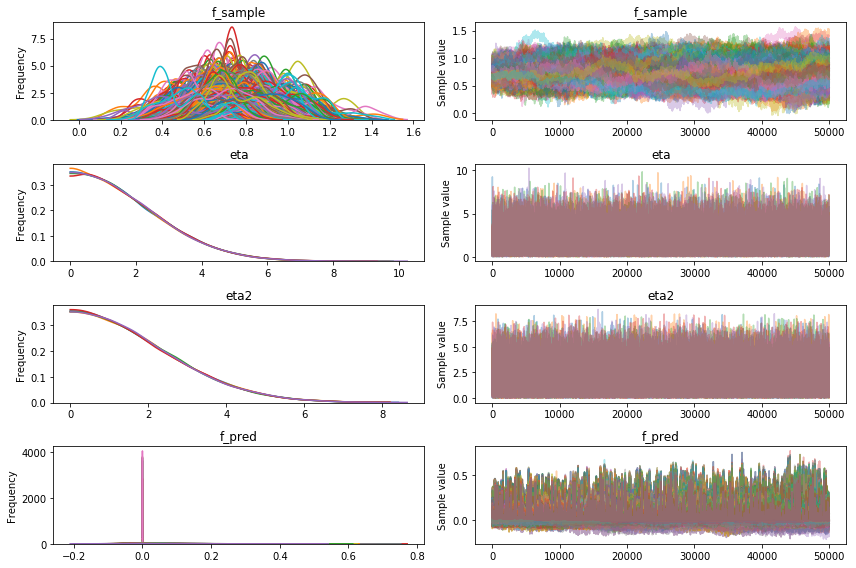

In [13]:
pm.traceplot(trace99);

In [42]:
with pm.Model() as model:
    eta = pm.HalfNormal("eta",tau=1/5)
    eta2 = pm.HalfNormal("eta2",tau=1)
    trace0 = pm.sample(2000, tuning = 800, progressbar=True, chains = 4, cores = 8)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 8 jobs)
NUTS: [eta2, eta]
Sampling 4 chains: 100%|██████████| 10000/10000 [00:04<00:00, 2251.96draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


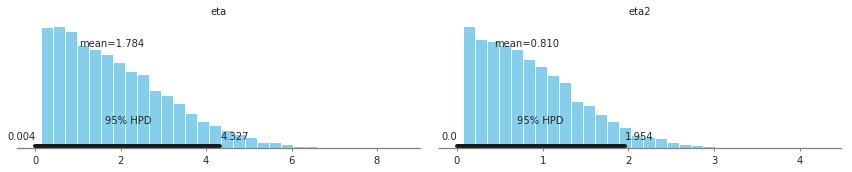

In [43]:
pm.plot_posterior(trace0, varnames=['eta', 'eta2']);

In [15]:
df = pd.DataFrame([trace['step_size'].mean(),trace2['step_size'].mean()], columns=['Step_size'])
df['Divergent'] = pd.Series([trace99['diverging'].sum(),trace2['diverging'].sum()])
df['delta_target'] = pd.Series(['.99', '.80'])
df

,Step_size,Divergent,delta_target
0,0.495621,550,.99
